# Cluster Analysis
The purpose of our cluster analysis is to:
- Measure clustering & central tendency.
- Perform k-means
- Evaluate the clusters, **particularly**:
    - does the dataset naturally cluster into people who do and do not have heart disease?
    - people with alchol abuse issues
    - underweight vs normal weight vs overweight vs obese

## Import libaries
### Data Processing 

In [1]:
import pandas as pd

### Scientific computing

In [2]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
from sklearn.preprocessing import StandardScaler

### Clustering

In [3]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from pyclustertend import ivat

### Data Visualisation

In [4]:
import matplotlib.pyplot as plt
import matplotlib
from yellowbrick.cluster import SilhouetteVisualizer
import seaborn as sns

## Measure Cluster Tendency
Clustering algorithms such as k-means are used to determine the structure of multi-dimensional data. Clusters are disjoint natural groups. However, K-means will find clusters in data even if none "actually" exist. Therefore, a fundamental question before applying any clustering algorithms is: Are clusters present at all?
We will measure the clustering tendency of both datasets before subjecting it to k-means. These datasets contain the top **two principal components (2D)**. To do this, we employ 
- Hopkins's statistic  of randomness


### Hopkins statistics
Hopkins statistics {cite:p}`banerjee2004validating` tests the spatial randomness of a dataset i.e. it measures the probability that a given dataset aligns with a uniform distribution. It is based on the difference between the distance from a real point to its nearest neighbour, U, and the distance from a uniformly generated point within the data space to the nearest real data point, W.

- $H_{0}$: The dataset **is** uniformly distributed 
- $H_{1}$: The dataset **is not** uniformly distributed 

$$
H = \frac{\sum_{i=1}^{m} u_{i}^{d}}{\sum_{i=1}^{m} u_{i}^{d} + \sum_{i=1}^{m} w_{i}^{d}}
$$

If the value of the Hopkins statistic(H) is close to 1 (above 0.5), we reject $H_{0}$ and can conclude that the dataset is considered significantly clusterable.  Otherwise, we fail to reject $H_{0}$ and can conclude that the dataset is considered significantly uniformly distributed.

In [5]:
def hopkins(X):
    """
    Hopkins statistic. Code snippet:
        https://matevzkunaver.wordpress.com/2017/06/20/hopkins-test-for-cluster-tendency/
    """
    d = X.shape[1]
    n = len(X) 
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [6]:
dim_reduced_2d = pd.read_csv('data/dim_reduced_2d.csv')
# Get labels as defined in the markdown cell above to compare how k-means cluster patients
original_heart_disease = pd.read_csv('data/heart_2020_cleaned.csv')
bins = [0, 18.5, 24.9, 29.9, np.inf]
names = ["UnderWeught", "NormalWeight", "Overweight", "Obese"]
dim_reduced_2d['BMI_Bin'] = pd.cut(original_heart_disease['BMI'], bins, labels=names)
dim_reduced_2d['AlcoholDrinking'] = original_heart_disease['AlcoholDrinking']
dim_reduced_2d['BMI_Bin'] = original_heart_disease['Smoking']

For both datasets, we reject $H_{0}$ and can conclude that the dataset has a significant tendency to cluster.

In [7]:
print(f"2D's hopkins statistic {hopkins(dim_reduced_2d.iloc[:,1:-2])}")

2D's hopkins statistic 0.9912240712158042


## K-Means

K-means is a common clustering algorithm. Although a simple clustering algorithm, it has vast application areas, including customer segmentation and image compression. K-means is a centroid based algorithm that aims to minimize the sum of distances between the points and their respective cluster centroid.  The main steps of this algorithm are:

- **Step 1**: Choose the number (k) of clusters
- **Step 2**: Select k random points, which will become the initial centroids
- **Step 3**: Assign all data points to the nearest centroid.
- **Step 4**: Compute the centroid of the newly formed clusters by taking the
mean of data instances currently associated with that cluster.
- **Step 5**: Repeat steps 3 and 4 until either:
    - Centroids of newly formed clusters do not change
    - Points remain in the same cluster
    - Maximum number of iterations are reached

We utlise the `MiniBatchKMeans()` from the sckit-learn package, given the largness of this dataset.

But how do we find the optimal number of clusters?
- Elbow method
- Silhouette coefficient

### Elbow method
The Elbow method calculates the error or 'distortion' between the data points ($y_{i}$) and their corresponding centroid ($ŷ_{i}$) of N data points for k clusters where k ⋹ {1...10}. The error metric used is the Sum of Squared Error (SSE):

$$
SSE = \sum_{i=1}^{N} {(y_i - ŷ_i)^2}
$$

We plot these values in an attempt to find an 'elbow' within the curve.

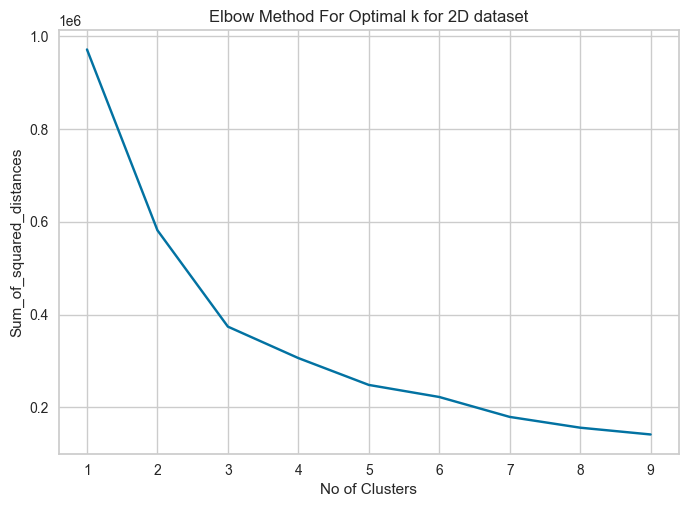

In [8]:
Sum_of_squared_distances = []
for k in range(1, 10):
    km_2d = MiniBatchKMeans(n_clusters=k, random_state=42)
    km_2d = km_2d.fit(dim_reduced_2d.iloc[:,1:-2])
    Sum_of_squared_distances.append(km_2d.inertia_)
plt.plot(range(1, 10), Sum_of_squared_distances, 'bx-')
plt.xlabel('No of Clusters')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k for 2D dataset')
plt.show()

We can see that the optimal number of clusters occur at k=2. A more suitable dip is noted at k-4.

## Sillhoute method

This method is another method of finding the correct number of clusters(k). Silhouette coefficient for a particular data point ($i$) is defined as:


$$
s_{i} = \frac{b_{i} - a_{i}}{max(b_{i}, a_{i})}
$$
where:
- $s_{i}$: the silhouette coefficient, ranging from -1 to 1. A score of 1 (the best) means that data point $i$ is compact in its cluster and far away from other clusters. Conversely, the worst value is -1, while values near 0 denote overlapping clusters.
- $b_{i}$: average distance between $i$ and all the other data points in its cluster. 
- $a_{i}$: minimum average distance from $i$ to all clusters to which $i$ does not belong to

We evaluate using silhouette plots. These plots display how close each point in one cluster is to points in the neighbouring clusters.

In [9]:
from yellowbrick.cluster import SilhouetteVisualizer
for k in  range(2,5):
    km = MiniBatchKMeans(n_clusters=k, random_state=42)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(dim_reduced_2d.iloc[:,1:-2])
    visualizer.show()

KeyboardInterrupt: 

The results of the silhoute analysis are more ambiguous.  K=2 seem to be sub-optimal due to wide fluctuations in size of the silhouette plot.  However, the fluctuation at k=4 seems to be more uniform compared to 2. Thus, we select the optimal number of clusters as 4.  


## Findings

As mentioned previously, clusters can be considered as disjoint groups. In this context, these clusters seek to represent people with similar latent physiological processes and/or possible health statuses. We attempt to relate the groupings to the health disease status of individual pateints.

### Top 2 principal component dataset

Healthy vs Unhealthy

,1,2,3,4
HeartDisease,,,,
0,116237.0,37359.0,22403.0,116423.0
1,16315.0,1832.0,7538.0,1688.0


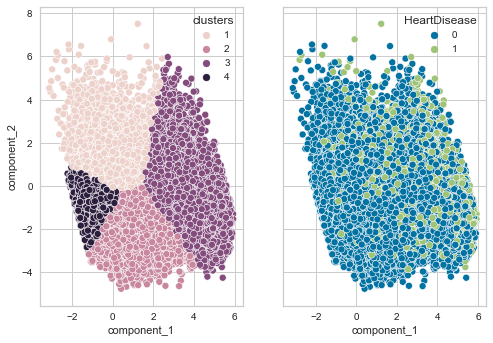

In [60]:

km_2d = KMeans(n_clusters=4, random_state=42).fit(dim_reduced_2d.iloc[:,1:-2])
dim_reduced_2d["clusters"] = km_2d.labels_ + 1
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.scatterplot(x='component_1', y='component_2', data=dim_reduced_2d, hue='clusters', ax=ax1)
sns.scatterplot(x='component_1', y='component_2', data=dim_reduced_2d, hue='HeartDisease', ax=ax2)
results_df = dim_reduced_2d[['HeartDisease', 'clusters']].set_index('HeartDisease')
results_df = results_df.apply(pd.Series.value_counts, axis=1).groupby(by=["HeartDisease"]).sum()
results_df

The majority of people with heart disease fall in cluster 1. Although a significant proportion also fall in cluster 2. This lines with our hypothesis that people who suffer from herat disease exhibit similar risk factors.

,1,2,3,4
BMI_Bin,,,,
UnderWeught,1805.0,816.0,803.0,1690.0
NormalWeight,36996.0,10932.0,6614.0,40592.0
Overweight,50829.0,11545.0,8885.0,43493.0
Obese,42922.0,15898.0,13639.0,32336.0


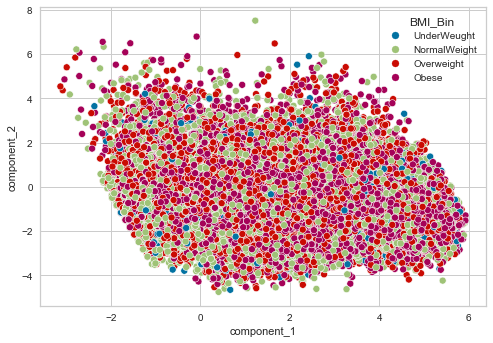

In [61]:
sns.scatterplot(x='component_1', y='component_2', data=dim_reduced_2d, hue='BMI_Bin')
results_df = dim_reduced_2d[['BMI_Bin', 'clusters']].set_index('BMI_Bin')
results_df = results_df.apply(pd.Series.value_counts, axis=1).groupby(by=["BMI_Bin"]).sum()
results_df

Besides the majority of overweight and obese patients falling in clusters 1 and 4, participants in each BMI group seem to be equally distributed among the clusters. If patients  could be accurately clustered by study, this would suggest that BMI would be a strong indicator of heart disease. However, this is not the case. It is possible that the clustering is not accurate enough to make such a conclusion, or that BMI has a mild influence on heart disease outcome.

In [82]:
def visualise_cluster_heat_map(focus_feature, k, df, cmap=None):
    """
    Visualizes the clusters as heat maps , where the squares represents 
        the number of particpants in k clusters grouped by the focus feature 
    
    :param focus_feature: focus_feature respresents the feature we want to
        drill down by i.e. health status or study
    :param k: Number of desired clusters
    :param df: Dataframe containing study, health status and the top 3 principal
        components
    :param cmap: matplotlib colormap name or object, or list of colors, optional
    """
    

    km_3d = KMeans(n_clusters=k, random_state=42).fit(dim_reduced_2d[["component_1", "component_2"]])
    df["clusters"] = km_3d.labels_ + 1
    df = df[[focus_feature, 'clusters']].set_index(focus_feature)
    df = df.apply(pd.Series.value_counts, axis=1).groupby(by=[focus_feature]).sum()
    akws = {"ha": 'left',"va": 'top'}
    ax = sns.heatmap(df, annot=True, cmap=cmap, fmt='g', annot_kws=akws)

    for t in ax.texts:
        trans = t.get_transform()
        offs = matplotlib.transforms.ScaledTranslation(-0.34, 0.34,
                        matplotlib.transforms.IdentityTransform())
        t.set_transform( offs + trans )
    
    plt.xlabel('clusters')
    plt.show()

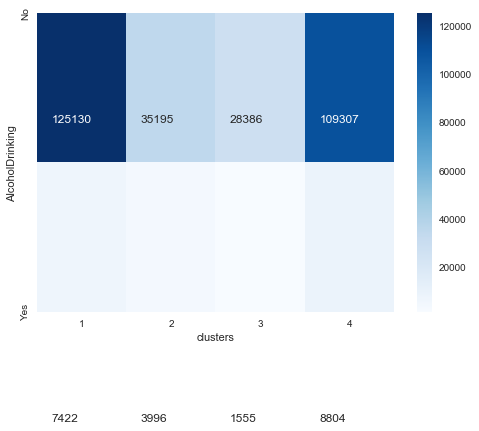

In [83]:
visualise_cluster_heat_map('AlcoholDrinking', 4, dim_reduced_2d, 'Blues')

The healthy participants seem to be evenly spread among the two clusters. Unhealthy participants have a tendency to appear in cluster 1 and 4. K-means seems to be reasonable able to cluster alcoholic  patients.

Finally, we decide to append the clusters to our standardized dataset. Our feature selection method later on, will tell us if they were of use or not. 

In [79]:
standradised_dataset = pd.read_csv('data/standardised_heart_disease.csv')
standradised_dataset["clusters"] = (dim_reduced_2d["clusters"]-dim_reduced_2d["clusters"].mean())/dim_reduced_2d["clusters"].std()
standradised_dataset["clusters"].to_csv('data/standardised_heart_disease.csv', index=False)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
